# IoT Streaming Analytics Demo
This is a demo notebook for Db2 Warehouse's integrated Apache Spark environment and how it can be used to process and land streaming data in Db2 tables. It runs through livy with a PySpark kernel.

If you are new to Db2 Warehouse and its integrated Apache Spark capabilities you may first want to check out this [overview article](http://www.ibmbigdatahub.com/blog/evolving-enterprise-data-warehouse-beyond-sql-apache-spark). This notebook also uses ibmdbpy. If you are new to ibmdbpy, please refer to this [folder](https://github.com/ibmdbanalytics/ibmdbpy).

![](https://ibm.box.com/shared/static/6dr6gou6xr1alfwnj6zkj0tbsyc64vda.png)

## Set up IoT demo data producer
This demo relies on a little data producer container that you have to set up in addition to your Db2 local and Jupyter notebook containers on the same host machine. You can find it [here](https://github.com/ibmdbanalytics/dashdb_analytic_tools/tree/notebook-dev/dashdblocal_notebooks/iot_producer) in a sub folder of the dashDB Jupyter notebook container project. Please follow the instructions found there and perform the few simple steps to set it up. 

This producer will set up a Kafka server on port `9092` with a Kafka topic named `iot4dashdb` and permanently flow in there messages about wind turbine device measurements.

## Streaming environment setup for Spark

**Imports**

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
import json
from pyspark.sql import SQLContext 
import warnings
warnings.filterwarnings("ignore")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
101,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Local visualisations will use pandas and matplotlib.

In [2]:
%local

%matplotlib inline

#Useful imports for local visualisations
import pandas as pd
import matplotlib.pyplot as plt

__Spark context__

Let's create a Spark context. Spark context sets up internal services and establishes a connection to a Spark execution environment. Once a SparkContext is created you can use it to create RDDs, accumulators and broadcast variables, access Spark services and run jobs (until SparkContext is stopped).

In [3]:
sc = SparkContext.getOrCreate()
sqlsc = SQLContext(sc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

__Kafka assembly__

We need the kafka streaming library in the classpath. Loading it via `%AddDep` magic does not currently work because of classloader issues (Spark datasource lookup doesn't find it). The Db2 Warehouse container gets the kafka library deployed in the subsequent step. So adding the dependency is not necessary to execute the code. However the goal of this notebook is to eventually export, compile and deploy it as a Spark application inside Db2. The compilation is going to be performed in the Jupyter container. For this reason we still need to add the kafka library as a compile-time dependency inside comments. The deployment function treats commented %AddDeps as a compile-only dependecy.

Let's check if you have Kafka assembly available:

In [4]:
import os

path = "/mnt/bludata0/home/bluadmin/spark/defaultlibs"
#to change if bluadmin is not your user name

kafka_assembly = "spark-streaming-kafka-0-8-assembly_2.11-2.3.0.jar"
url = "http://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.3.0/" + kafka_assembly

if (os.path.exists(path + "/" + kafka_assembly)):
    print("Kafka assembly found")
else:
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'
    print ("Please download the Kafka assembly from the following link: "+url+" and restart the notebook")


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Kafka assembly found

__Kafka configuration to connect to our IoT demo data producer__

Now we define a utility function to set up a Kafka Streaming context, and run it for an optionally defined period of time with a given processing function. 

**Important note** : When we run this interactively in a notebook cell, it's important to set the timeout to a specific value to stop the streaming context. Otherwise it will keep running and produce cell output, even after the cell has finished executing. This timeout is defined in ssc.awaitTerminationOrTimeout().

Note also that a streaming context cannot be re-used after it has executed, so we can't keep it across cells and therefore we have to use the utility function to re-create it before every execution.

We use a `finally` block to make sure the context is stopped even in case of exception; otherwise the whole streaming infrastructure becomes unusable within the notebook kernel's lifetime.

In [5]:
topics=["iot4dashdb"]

def runStreamingContext(rdd):
    sc = SparkContext.getOrCreate()
    sqlsc = SQLContext(sc)
    ssc = StreamingContext(sc,3)
    
    messages = KafkaUtils.createDirectStream(ssc, \
                                         topics, \
                                         kafkaParams = {"metadata.broker.list": "localhost:9092"})
    
    messages.foreachRDD(rdd)
    
    try:
        ssc.start()
        ssc.awaitTerminationOrTimeout(50)
    finally:
        ssc.stop(stopSparkContext=False, stopGraceFully=True)
    



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data exploration

First, we simply iterate over the batch RDDs and print out their content, just to explore the data in our Kafka queue.

__Important note__: Before you execute the cell below, you will need to start the producer container that writes into the kafka queue. When the IoT producer container is not started or has already terminated, the streaming computation in the following cell will hang and never return.

In [6]:
def processStream0(rdd):
    for x in rdd.collect():
        print(x[1])

runStreamingContext(processStream0)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{"payload": {"temperature": 32,"tempOutside": 18,"powerProd": 1830,"noiseLevel1": 82,"time":"2019-10-01 07:53:37"},"deviceId": "2703","deviceType": "windGen","eventType": "status"}
{"payload": {"temperature": 33,"tempOutside": 18,"powerProd": 1831,"noiseLevel1": 82,"time":"2019-10-01 07:53:39"},"deviceId": "2703","deviceType": "windGen","eventType": "status"}
{"payload": {"temperature": 31,"tempOutside": 18,"powerProd": 1834,"noiseLevel1": 82,"time":"2019-10-01 07:53:41"},"deviceId": "2704","deviceType": "windGen","eventType": "status"}
{"payload": {"temperature": 30,"tempOutside": 18,"powerProd": 1830,"noiseLevel1": 82,"time":"2019-10-01 07:53:42"},"deviceId": "2702","deviceType": "windGen","eventType": "status"}
{"payload": {"temperature": 34,"tempOutside": 18,"powerProd": 1836,"noiseLevel1": 82,"time":"2019-10-01 07:53:44"},"deviceId": "2703","deviceType": "windGen","eventType": "status"}
{"payload": {"temperature": 37,"tempOutside": 18,"powerProd": 1835,"noiseLevel1": 82,"time":"20

So this gives us an idea about the JSON format we can expect from our data source. Lets parse each batch into a DataSet with Spark SQL. We don't want Spark to perform automatic JSON schema detection over and over again for each batch, so we give it a pre-defined schema as follows.

In [7]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, TimestampType
schema = StructType([StructField("payload", 
                                StructType([StructField("temperature", LongType()),
                                            StructField("tempOutside", LongType()),
                                            StructField("powerProd", LongType()),
                                            StructField("noiseLevel1", LongType()),
                                            StructField("time", TimestampType())])),
                    StructField("deviceId", StringType()),
                    StructField("deviceType", StringType()),
                    StructField("eventType", StringType())])


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

As we can see, the produced data has a nested structure. 
Spark can deal with this type of schema, but it's not suitable being stored in a plain SQL database table, so we flatten it to straight rows by creating a dataframe.

In [8]:
from pyspark.sql.functions import expr

def processStream1(rdd):
    rdd2 = rdd.map(lambda x: x[1])
    df = sqlsc.read.json(rdd2, schema)
    df.select(["payload.temperature", "payload.tempOutside", "payload.powerProd", "payload.noiseLevel1", "payload.time", "deviceId", "deviceType", "eventType"]).show()

runStreamingContext(processStream1)   

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|temperature|tempOutside|powerProd|noiseLevel1|               time|deviceId|deviceType|eventType|
+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|         31|         18|     1834|         82|2019-10-01 07:54:38|    2701|   windGen|   status|
+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+

+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|temperature|tempOutside|powerProd|noiseLevel1|               time|deviceId|deviceType|eventType|
+-----------+-----------+---------+-----------+-------------------+--------+----------+---------+
|         33|         18|     1827|         82|2019-10-01 07:54:40|    2708|   windGen|   status|
|         35|         18|     1832|         82|2019-10-01 07:54:42|    2707|   windGen|   status|
+-----------+------

## Write IoT records to a persistent table

In the desired deployed application we want to write the records read from the queue into a Db2 table instead of only printing out the datasets. In this demonstration here we will always first *empty* the table in the first batch after the application is started. We use Spark's *'Overwrite'* mode for writing the first batch to clear a pre-existing table and then use *'Append'* mode in subsequent batches.

You can check in your Db2 Warehouse console that a table called USERDATA.IOT_EVENTS has been created. For example, run the following SQL query to see how many records have been written: 
> SELECT COUNT(*) FROM USERDATA.IOT_EVENTS.

In [9]:
tableName= "USERDATA.IOT_EVENTS"
savemode = 'overwrite'

def processStream2(rdd):
    global savemode
    rdd2 = rdd.map(lambda x: x[1])
    df = sqlsc.read.json(rdd2, schema)
    df2=df.select(["payload.temperature", 
               "payload.tempOutside", 
               "payload.powerProd", 
               "payload.noiseLevel1", 
               "payload.time", 
               "deviceId", 
               "deviceType", 
               "eventType"])
    
    
    df2.write.format("com.ibm.idax.spark.idaxsource").\
    option("dbtable", tableName ).\
    option("allowAppend", "TRUE").\
    mode(savemode).\
    save()
    
    print("Batch written to database")
    savemode ='append'
    
runStreamingContext(processStream2)
    


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database
Batch written to database

You will notice that there are only a few rows compared to the number of generated records. For example, with a timeout set to 10s, you will collect approximately 8 rows. With a timeout of 50s, there will be approximetely 30 etc.

## Check landed IoT data
You can verify the landed data in Db2 Warehouse. For this we simply establish a dataframe on the result table.

In [10]:
sparkSession = spark \
        .builder \
        .getOrCreate()

df_check = spark.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable=tableName) \
        .load()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we show the content. You can verify the progress of your deployed landing app by running the next cell repeatetly and check the new records and overall count.

In [11]:
print("Total IoT Records: "+ str(df_check.count()))
print("Showing Newest "+str(df_check.count()) +" Records:")
df_check.select("deviceId", "time", "temperature", "tempOutside", "powerProd", "noiseLevel1").\
                orderBy("time", ascending=False).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total IoT Records: 30
Showing Newest 30 Records:
+--------+-------------------+-----------+-----------+---------+-----------+
|deviceId|               time|temperature|tempOutside|powerProd|noiseLevel1|
+--------+-------------------+-----------+-----------+---------+-----------+
|    2705|2019-10-01 07:56:27|         38|         18|     1828|         82|
|    2700|2019-10-01 07:56:25|         36|         18|     1827|         82|
|    2704|2019-10-01 07:56:23|         32|         18|     1830|         82|
|    2704|2019-10-01 07:56:22|         35|         18|     1829|         82|
|    2703|2019-10-01 07:56:20|         31|         18|     1828|         82|
|    2707|2019-10-01 07:56:18|         32|         18|     1828|         82|
|    2701|2019-10-01 07:56:16|         34|         18|     1830|         82|
|    2708|2019-10-01 07:56:15|         34|         18|     1836|         82|
|    2703|2019-10-01 07:56:13|         31|         18|     1835|         82|
|    2701|2019-10-01 07:56:

## Visualisation of time series

You could want to visualize the data you are collecting. Let's plot some of the features over time.

__Note : Make a bridge between remote and local__

So far we've been using Spark servers and the data is accessed remotely. If we plot visualisations now, they won't appear right on your screen : you will have to fetch them, using their adress, to open them locally. So for convenience, visualisations will be made locally thanks to the __%local__ magic. Therefore, we need to create a temporary view of the data, and query it with the %%sql magic in order to access it locally and plot it directly. Note that the data on the Spark cluster is a Spark dataframe, whereas the data we handle locally is a pandas dataframe.

In the following cells, we will:
1. Create a SQL temporary view of the tornado (Spark) dataframe
2. Run a %%sql cell magic to query the data, and output it to the local space. The table is now seen as a Pandas dataframe.
3. We use this Pandas dataframe to make our graphs, which we output locally.

In [12]:
df_check.createOrReplaceTempView('turbine')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
%%sql -o turbine --maxrows -1
SELECT * FROM turbine

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [14]:
%local
turbine['time']=pd.to_datetime(turbine['time'])

As you may have noticed, our data comes from several devices. Let's focus on only one device to start with. You can change the deviceId if you like.

In [19]:
%local
print(turbine['deviceId'].unique())
device=turbine[turbine['deviceId']==2704] #your choice

[2707 2703 2701 2704 2700 2708 2706 2709 2705]


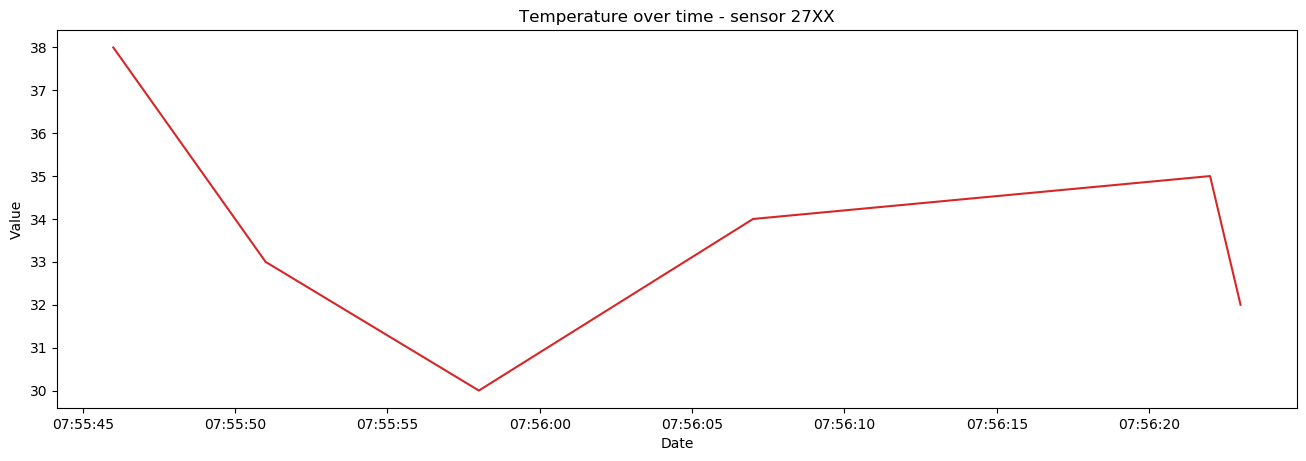

In [20]:
%local

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Basic plot
def plot_df(dataFrame, x1, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x1, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(device, x1=device.time, y=device.temperature, title='Temperature over time - sensor 27XX')    

It could be useful to compare the temperature measured by the sensor with the power production over time. Is the temperature raising over time? Does an increase in power production implies an increase in temperature? With some lag?

Note that the data generator we used here doesn't provide very meaningful data regarding Physics... Furthermore, we would need a far longer observation time to make any conclusion. However, the following visualisations are provided for the sake of our use case.

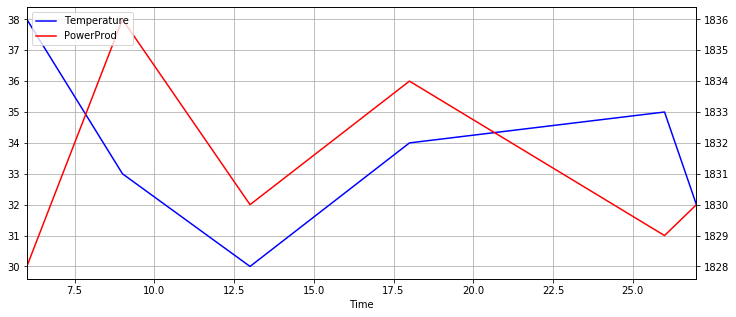

In [21]:
%local

# Temperature and power production over time 
# in a particular sensor

plt.figure(figsize=(12,5))
plt.xlabel('Time')

ax1 = device.temperature.plot(color='blue', grid=True, label='Temperature')
ax2 = device.powerProd.plot(color='red', grid=True, secondary_y=True, label='PowerProd')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

__All devices put together__

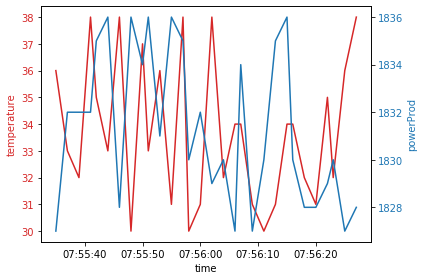

In [18]:
%local

# Create some mock data
t = turbine.time
data1 = turbine.temperature
data2 = turbine.powerProd

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('temperature', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('powerProd', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


___
### Authors

__Eva Feillet__ is intern at IBM Research Lab in Böblingen. She comes from CentraleSupelec Engineering School in France and has studied deep learning at the Technical University of Munich. She is passionate about data science and eager to apply it to real-life use cases.

**Toni Bollinger** Consulting IT Specialist, IBM Cloud and Cognitive Software, Böblingen, Germany

Copyright © 2019 IBM Corporation. All rights reserved.